In [ ]:
import numpy as np
import nltk
import pandas as pd
import collections
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount("/content/drive/")
df=pd.read_csv("drive/My Drive/NLP summer Internship/Cleanned_Complaints.csv")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Show label distribution for the whole original dataset
df.groupby("Label")["Complaint"].count()

Label
Bank account or service                                                          14885
Checking or savings account                                                      22433
Consumer Loan                                                                     9473
Credit card or prepaid card                                                      58843
Credit reporting, credit repair services, or other personal consumer reports    212882
Debt collection                                                                 116679
Money transfer, virtual currency, or money service                               10692
Mortgage                                                                         66256
Other financial service                                                            292
Payday loan, title loan, or personal loan                                         9189
Student loan                                                                     26411
Vehicle loan or lease                

In [ ]:
# Groupby and count companies complaints
df.groupby("Company")["Label"].count().sort_values(ascending=False)[:20]

Company
EQUIFAX, INC.                             61377
Experian Information Solutions Inc.       56355
TRANSUNION INTERMEDIATE HOLDINGS, INC.    55067
CITIBANK, N.A.                            18261
WELLS FARGO & COMPANY                     17618
BANK OF AMERICA, NATIONAL ASSOCIATION     17302
JPMORGAN CHASE & CO.                      17185
CAPITAL ONE FINANCIAL CORPORATION         15016
Navient Solutions, LLC.                   14878
SYNCHRONY FINANCIAL                        9992
AMERICAN EXPRESS COMPANY                   6418
Ocwen Financial Corporation                5811
U.S. BANCORP                               5587
NATIONSTAR MORTGAGE                        5564
AES/PHEAA                                  5508
PORTFOLIO RECOVERY ASSOCIATES INC          5485
ENCORE CAPITAL GROUP INC.                  4615
DISCOVER BANK                              4480
Alliance Data Card Services                4222
Ditech Financial LLC                       3979
Name: Label, dtype: int64

In [ ]:
# Prepare three vendor dataset and one test set
df_wells=df[df["Company"]=="WELLS FARGO & COMPANY"]
credit_unions=["EQUIFAX, INC.","TRANSUNION INTERMEDIATE HOLDINGS, INC."]
banks=["CITIBANK, N.A.","BANK OF AMERICA, NATIONAL ASSOCIATION","JPMORGAN CHASE & CO.","U.S. BANCORP"]
mortgages=["Ocwen Financial Corporation","NATIONSTAR MORTGAGE"]
df_cu=df[df["Company"].isin(credit_unions)]
df_banks=df[df["Company"].isin(banks)]
df_mortgages=df[df["Company"].isin(mortgages)]
df_cu=df_cu.dropna()
df_banks=df_banks.dropna()
df_mortgages=df_mortgages.dropna()

In [ ]:
# Dataset label distributions
cu_label_count=df_cu.groupby("Label")["Complaint"].count()/len(df_cu)
banks_label_count=df_banks.groupby("Label")["Complaint"].count()/len(df_banks)
mortgages_label_count=df_mortgages.groupby("Label")["Complaint"].count()/len(df_mortgages)
wells_label_count=df_wells.groupby("Label")["Complaint"].count()/len(df_wells)
print(cu_label_count)
print(banks_label_count)
print(mortgages_label_count)
print(wells_label_count)

Label
Bank account or service                                                         0.000034
Checking or savings account                                                     0.000060
Consumer Loan                                                                   0.000283
Credit card or prepaid card                                                     0.001469
Credit reporting, credit repair services, or other personal consumer reports    0.983156
Debt collection                                                                 0.013821
Money transfer, virtual currency, or money service                              0.000077
Mortgage                                                                        0.000352
Other financial service                                                         0.000009
Payday loan, title loan, or personal loan                                       0.000129
Student loan                                                                    0.000326
Vehicle loan or

In [ ]:
# Corpus of the four dataset
cu_complaint=df_cu["Complaint_reduced"]
banks_complaint=df_banks["Complaint_reduced"]
mortgages_complaint=df_mortgages["Complaint_reduced"]
wells_complaint=df_wells["Complaint_reduced"]

In [ ]:
print(cu_complaint.shape,banks_complaint.shape,mortgages_complaint.shape,wells_complaint.shape)

(116421,) (58333,) (11374,) (17618,)


In [ ]:
# Helper function for tokenizers
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
def tokenizing(df,max_features):
  vectorizer=CountVectorizer(max_features=max_features)
  X= vectorizer.fit_transform(df)
  return vectorizer,X

def tfidf_tokenizing(df,max_features,norm):
  vectorizer=TfidfVectorizer(use_idf=True,norm=norm,smooth_idf=True,max_features=max_features)
  X= vectorizer.fit_transform(df)
  return vectorizer,X

EDA - overlapping tokens

In [ ]:
# Compare words overlapping first m frequent words for the whole dataset
# Number of word overlapping/m 
cu_wells=[]
mortgages_wells=[]
banks_wells=[]
for i in range(1,6):
  max_features=i*1000
  #vectorizer
  cu_vectorizer,X_cu=tokenizing(cu_complaint,max_features)
  banks_vectorizer,X_banks=tokenizing(banks_complaint,max_features)
  mortgages_vectorizer,X_mortgages=tokenizing(mortgages_complaint,max_features)
  wells_vectorizer,X_wells=tokenizing(wells_complaint,max_features)
  #get frequent words
  cu_fq_words=cu_vectorizer.get_feature_names()
  banks_fq_words=banks_vectorizer.get_feature_names()
  mortgages_fq_words=mortgages_vectorizer.get_feature_names()
  wells_fq_words=wells_vectorizer.get_feature_names()
  # calculate overlap percentage
  overlap_cu_wells=len(set(cu_fq_words)&set(wells_fq_words))/max_features
  overlap_banks_wells=len(set(banks_fq_words)&set(wells_fq_words))/max_features
  overlap_mortgages_wells=len(set(mortgages_fq_words)&set(wells_fq_words))/max_features
  # Append percentages to the list
  cu_wells.append(overlap_cu_wells)
  mortgages_wells.append(overlap_mortgages_wells)
  banks_wells.append(overlap_banks_wells)

# Print degree of overlapping
print(f'cu-wells-overlap',cu_wells)
print(f'mortgages-wells-overlap',mortgages_wells)
print(f'banks-wells-overlap',banks_wells)

cu-wells-overlap [0.776, 0.822, 0.8253333333333334, 0.817, 0.8012]
mortgages-wells-overlap [0.873, 0.879, 0.879, 0.86275, 0.8336]
banks-wells-overlap [0.908, 0.92, 0.9066666666666666, 0.89925, 0.885]


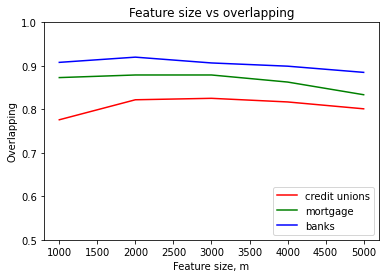

In [ ]:
# Plot degree of overlapping for different size m
x=[1000,2000,3000,4000,5000]
plt.plot(x,cu_wells,color="red",label="credit unions")
plt.plot(x,mortgages_wells,color="green",label="mortgage")
plt.plot(x,banks_wells,color="blue",label="banks")
plt.legend(loc="lower right")
plt.xlabel("Feature size, m")
plt.ylabel("Overlapping")
plt.title("Feature size vs overlapping")
plt.ylim(0.5, 1)
plt.show()

EDA word cloud

Approach 1.1 Overlapping frequent word

1.1.1 Dimension reduction and choose max_feature size for corpus

In [ ]:
# Count all vocaburary frequency in all dataset, set max_features to None
cu_vectorizer,X_cu=tokenizing(cu_complaint,None)
banks_vectorizer,X_banks=tokenizing(banks_complaint,None)
mortgages_vectorizer,X_mortgages=tokenizing(mortgages_complaint,None)
wells_vectorizer,X_wells=tokenizing(wells_complaint,None)
cu_freq=X_cu.sum(axis=0)
banks_freq=X_banks.sum(axis=0)
mortgages_freq=X_mortgages.sum(axis=0)
wells_freq=X_wells.sum(axis=0)
cu_freq=np.sort(np.squeeze(np.asarray(cu_freq)))[::-1]/cu_freq.sum()
banks_freq=np.sort(np.squeeze(np.asarray(banks_freq)))[::-1]/banks_freq.sum()
mortgages_freq=np.sort(np.squeeze(np.asarray(mortgages_freq)))[::-1]/mortgages_freq.sum()
wells_freq=np.sort(np.squeeze(np.asarray(wells_freq)))[::-1]/wells_freq.sum()

In [ ]:
# Helper function for the plot
# Argument:
# Title: Str
# freq_array: np.array, shape=(#tokens,)
# bin_size: int, such as 1000,2000
# Threshold: float, such as 0.95, function will print first size when hit threshold
def m_vs_token(title,freq_array,bin_size,threshold):
  total_size=freq_array.shape[0]
  axis=[]
  total_freq=[]
  for i in range(bin_size,total_size,bin_size):
    axis.append(i)
    temp=freq_array[:i].sum()
    total_freq.append(temp)
  plt.xlabel("m size")
  plt.ylabel("token coverage")
  plt.plot(axis,total_freq)
  plt.show()
  k=0
  while total_freq[k]<threshold:
    k+=1
  print(axis[k])

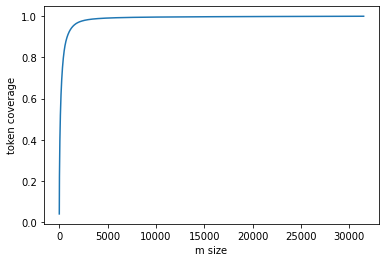

1384


In [ ]:
m_vs_token("CU_dataset",cu_freq,1,0.95)

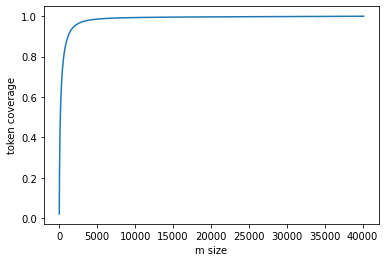

1968


In [ ]:
m_vs_token("banks_dataset",banks_freq,1,0.95)

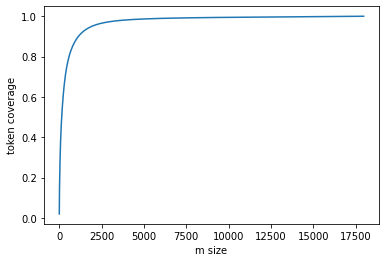

1919


In [ ]:
m_vs_token("mortgages_dataset",mortgages_freq,1,0.95)

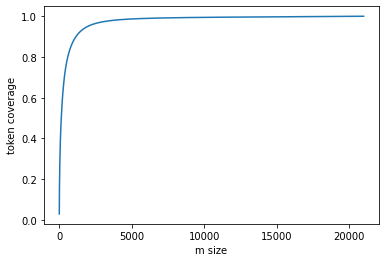

1957


In [ ]:
m_vs_token("wells_dataset",wells_freq,1,0.95)

Comment:
2000 seeems to be a safe choice

In [ ]:
#count tokenizer overlap score computation
max_features=2000 # this can be modified

cu_vectorizer,X_cu=tokenizing(cu_complaint,max_features)
banks_vectorizer,X_banks=tokenizing(banks_complaint,max_features)
mortgages_vectorizer,X_mortgages=tokenizing(mortgages_complaint,max_features)
wells_vectorizer,X_wells=tokenizing(wells_complaint,max_features)

cu_fq_words=cu_vectorizer.get_feature_names()
banks_fq_words=banks_vectorizer.get_feature_names()
mortgages_fq_words=mortgages_vectorizer.get_feature_names()
wells_fq_words=wells_vectorizer.get_feature_names()

#calculating original sentence word count
smoothing=0.001
wells_words_count=X_wells.toarray().sum(axis=1)+smoothing

#finding overlaping words
wells_cu_overlap=set(cu_fq_words)&set(wells_fq_words)
wells_banks_overlap=set(banks_fq_words)&set(wells_fq_words)
wells_mortgages_overlap=set(mortgages_fq_words)&set(wells_fq_words)

#searching overlaping index
wells_cu_overlap_idx=[wells_vectorizer.vocabulary_[i] for i in wells_cu_overlap]
wells_banks_overlap_idx=[wells_vectorizer.vocabulary_[i] for i in wells_banks_overlap]
wells_mortgages_overlap_idx=[wells_vectorizer.vocabulary_[i] for i in wells_mortgages_overlap]

#calculating sentence ovelapping word count
wells_cu_overlap_word_count=X_wells[:,wells_cu_overlap_idx].toarray().sum(axis=1)
wells_banks_overlap_word_count=X_wells[:,wells_banks_overlap_idx].toarray().sum(axis=1)
wells_mortgages_overlap_word_count=X_wells[:,wells_mortgages_overlap_idx].toarray().sum(axis=1)

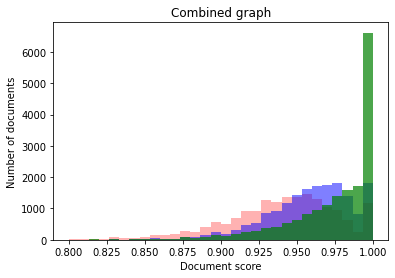

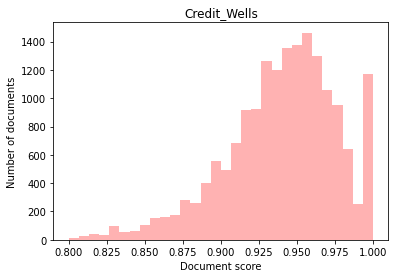

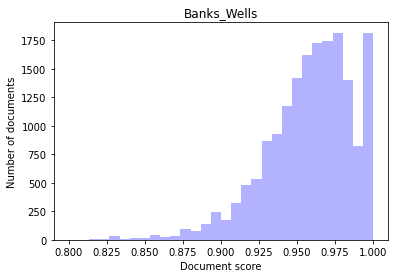

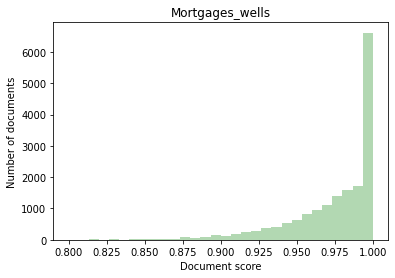

In [ ]:
#plot overlap distribution - count tokenizer
wells_cu_sentence_score=wells_cu_overlap_word_count/wells_words_count
wells_banks_sentence_score=wells_banks_overlap_word_count/wells_words_count
wells_mortgages_sentence_score=wells_mortgages_overlap_word_count/wells_words_count

plt.title("Combined graph")
plt.xlabel("Document score")
plt.ylabel("Number of documents")
plt.hist(wells_cu_sentence_score,alpha=0.3,bins=30,range=(0.8,1),color="red")
plt.hist(wells_banks_sentence_score,alpha=0.5,bins=30,range=(0.8,1),color="blue")
plt.hist(wells_mortgages_sentence_score,alpha=0.7,bins=30,range=(0.8,1),color="green")
plt.show()

plt.title("Credit_Wells")
plt.xlabel("Document score")
plt.ylabel("Number of documents")
plt.hist(wells_cu_sentence_score,alpha=0.3,bins=30,range=(0.8,1),color="red")
plt.show()

plt.title("Banks_Wells")
plt.xlabel("Document score")
plt.ylabel("Number of documents")
plt.hist(wells_banks_sentence_score,alpha=0.3,bins=30,range=(0.8,1),color="blue")
plt.show()

plt.title("Mortgages_wells")
plt.xlabel("Document score")
plt.ylabel("Number of documents")
plt.hist(wells_mortgages_sentence_score,alpha=0.3,bins=30,range=(0.8,1),color="green")
plt.show()

Approach 1.2 Overlapping frequent word with TFIDF coverage as score

In [ ]:
#tfidf overlap score computation
max_features=2000

cu_tfidf_vectorizer,X_tfidf_cu=tfidf_tokenizing(cu_complaint,max_features,"l1")
banks_tfidf_vectorizer,X_tfidf_banks=tfidf_tokenizing(banks_complaint,max_features,"l1")
mortgages_tfidf_vectorizer,X_tfidf_mortgages=tfidf_tokenizing(mortgages_complaint,max_features,"l1")
wells_tfidf_vectorizer,X_tfidf_wells=tfidf_tokenizing(wells_complaint,max_features,"l1")

cu_fq_tfidf_words=cu_tfidf_vectorizer.get_feature_names()
banks_fq_tfidf_words=banks_tfidf_vectorizer.get_feature_names()
mortgages_fq_tfidf_words=mortgages_tfidf_vectorizer.get_feature_names()
wells_fq_tfidf_words=wells_tfidf_vectorizer.get_feature_names()

#finding overlaping words
wells_cu_tfidf_overlap=set(cu_fq_tfidf_words)&set(wells_fq_tfidf_words)
wells_banks_tfidf_overlap=set(banks_fq_tfidf_words)&set(wells_fq_tfidf_words)
wells_mortgages_tfidf_overlap=set(mortgages_fq_tfidf_words)&set(wells_fq_tfidf_words)

#searching overlaping index
wells_cu_tfidf_overlap_idx=[wells_tfidf_vectorizer.vocabulary_[i] for i in wells_cu_tfidf_overlap]
wells_banks_tfidf_overlap_idx=[wells_tfidf_vectorizer.vocabulary_[i] for i in wells_banks_tfidf_overlap]
wells_mortgages_tfidf_overlap_idx=[wells_tfidf_vectorizer.vocabulary_[i] for i in wells_mortgages_tfidf_overlap]

#calculating sentence ovelapping word count
wells_cu_tfidf_overlap_sum=X_tfidf_wells[:,wells_cu_tfidf_overlap_idx].toarray().sum(axis=1)
wells_banks_tfidf_overlap_sum=X_tfidf_wells[:,wells_banks_tfidf_overlap_idx].toarray().sum(axis=1)
wells_mortgages_tfidf_overlap_sum=X_tfidf_wells[:,wells_mortgages_tfidf_overlap_idx].toarray().sum(axis=1)

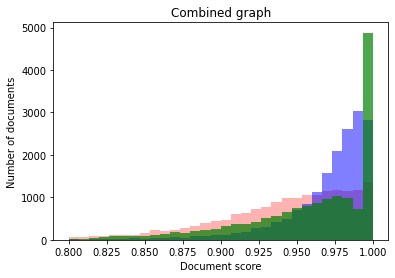

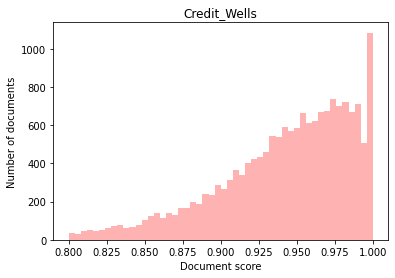

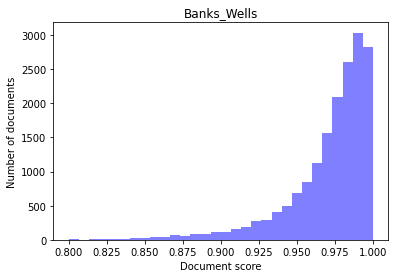

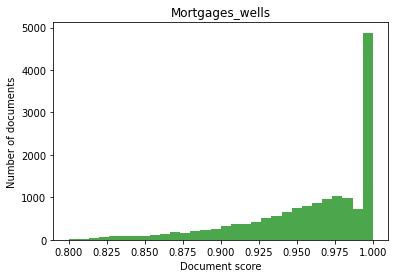

In [ ]:
#plot overlap distribution - tfidf tokenizer
wells_cu_tfidf_sentence_score=wells_cu_tfidf_overlap_sum
wells_banks_tfidf_sentence_score=wells_banks_tfidf_overlap_sum
wells_mortgages_tfidf_sentence_score=wells_mortgages_tfidf_overlap_sum

plt.title("Combined graph")
plt.xlabel("Document score")
plt.ylabel("Number of documents")
plt.hist(wells_cu_tfidf_sentence_score,alpha=0.3,bins=30,range=(0.8,1),color="red")
plt.hist(wells_banks_tfidf_sentence_score,alpha=0.5,bins=30,range=(0.8,1),color="blue")
plt.hist(wells_mortgages_tfidf_sentence_score,alpha=0.7,bins=30,range=(0.8,1),color="green")
plt.show()

plt.title("Credit_Wells")
plt.xlabel("Document score")
plt.ylabel("Number of documents")
plt.hist(wells_cu_tfidf_sentence_score,alpha=0.3,bins=50,range=(0.8,1),color="red")
plt.show()

plt.title("Banks_Wells")
plt.xlabel("Document score")
plt.ylabel("Number of documents")
plt.hist(wells_banks_tfidf_sentence_score,alpha=0.5,bins=30,range=(0.8,1),color="blue")
plt.show()

plt.title("Mortgages_wells")
plt.xlabel("Document score")
plt.ylabel("Number of documents")
plt.hist(wells_mortgages_tfidf_sentence_score,alpha=0.7,bins=30,range=(0.8,1),color="green")
plt.show()

Approach 1.3 Overlapping top TFIDF word with TFIDF coverage as score

In [ ]:
#TFIDF score for individual word. TF calculated using whole dataset
#This is soley for deciding which vocaburay are selected and feature size.
#Reuse the code snippet to find full count tokenizer for all sets
cu_vectorizer,X_cu=tokenizing(cu_complaint,None)
banks_vectorizer,X_banks=tokenizing(banks_complaint,None)
mortgages_vectorizer,X_mortgages=tokenizing(mortgages_complaint,None)
wells_vectorizer,X_wells=tokenizing(wells_complaint,None)

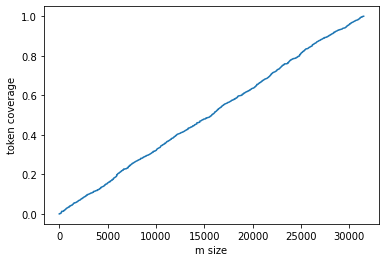

29750


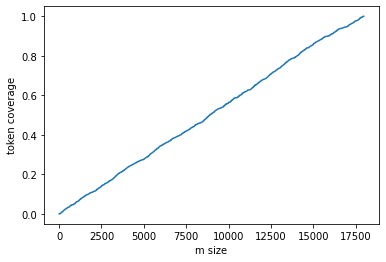

17060


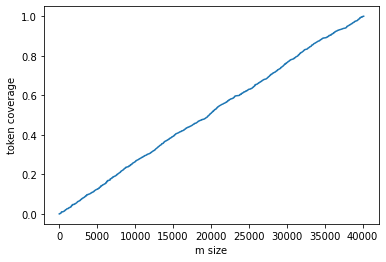

38000


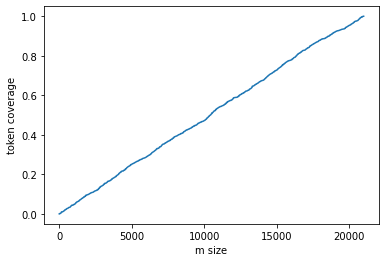

19930


In [ ]:
#Calculate each vocab's TF idf score
#cu dataset
cu_total_tfidf=np.asarray(np.multiply(X_cu.sum(axis=0),np.log(X_cu.shape[0]/((X_cu!=0).sum(axis=0)))))[0]
cu_total_tfidf_percent=cu_total_tfidf/sum(cu_total_tfidf)
m_vs_token("cu graph",cu_total_tfidf_percent,10,0.95)

#mortgage dataset
mortgages_total_tfidf=np.asarray(np.multiply(X_mortgages.sum(axis=0),np.log(X_mortgages.shape[0]/((X_mortgages!=0).sum(axis=0)))))[0]
mortgages_total_tfidf_percent=mortgages_total_tfidf/sum(mortgages_total_tfidf)
m_vs_token("mortgages graph",mortgages_total_tfidf_percent,10,0.95)

#banks dataset
banks_total_tfidf=np.asarray(np.multiply(X_banks.sum(axis=0),np.log(X_banks.shape[0]/((X_banks!=0).sum(axis=0)))))[0]
banks_total_tfidf_percent=banks_total_tfidf/sum(banks_total_tfidf)
m_vs_token("banks graph",banks_total_tfidf_percent,10,0.95)

#Wells Fargo datset
wells_total_tfidf=np.asarray(np.multiply(X_wells.sum(axis=0),np.log(X_wells.shape[0]/((X_wells!=0).sum(axis=0)))))[0]
wells_total_tfidf_percent=wells_total_tfidf/sum(wells_total_tfidf)
m_vs_token("wells graph",wells_total_tfidf_percent,10,0.95)

In [ ]:
#This code block is for finding index of top tfidf words in the dataset. Then find overlap vocabs between vendor vs Wells fargo dataset within these vocabs.
max_features=2000
#find top tfidf score word index from each dataset
cu_max_tfidf_idx=np.squeeze(np.asarray(cu_total_tfidf)).argsort()[-max_features:][::-1]
mortgages_max_tfidf_idx=np.squeeze(np.asarray(mortgages_total_tfidf)).argsort()[-max_features:][::-1]
banks_max_tfidf_idx=np.squeeze(np.asarray(banks_total_tfidf)).argsort()[-max_features:][::-1]
wells_max_tfidf_idx=np.squeeze(np.asarray(wells_total_tfidf)).argsort()[-max_features:][::-1]
#find vocab for all dataset
cu_vocab=cu_vectorizer.get_feature_names()
mortgages_vocab=mortgages_vectorizer.get_feature_names()
banks_vocab=banks_vectorizer.get_feature_names()
wells_vocab=wells_vectorizer.get_feature_names()
#find top tfidf score word from each dataset using the index
cu_max_tfidf_vocab=[cu_vocab[idx] for idx in cu_max_tfidf_idx]
mortgages_max_tfidf_vocab=[mortgages_vocab[idx] for idx in mortgages_max_tfidf_idx]
banks_max_tfidf_vocab=[banks_vocab[idx] for idx in banks_max_tfidf_idx]
wells_max_tfidf_vocab=[wells_vocab[idx] for idx in wells_max_tfidf_idx]
#find overlap vocab
cu_wells_overlap=list(set(cu_max_tfidf_vocab) & set(wells_max_tfidf_vocab))
banks_wells_overlap=list(set(mortgages_max_tfidf_vocab) & set(wells_max_tfidf_vocab))
mortgages_wells_overlap=list(set(banks_max_tfidf_vocab) &set (wells_max_tfidf_vocab))
#find overlap vocab index in wells_fargo matrix
# cu_wells_overlap_idx=[wells_vectorizer.vocabulary_[i] for i in cu_wells_overlap]
# mortgages_wells_overlap_idx=[wells_vectorizer.vocabulary_[i] for i in mortgages_wells_overlap]
# banks_wells_overlap_idx=[wells_vectorizer.vocabulary_[i] for i in banks_wells_overlap]

In [ ]:
# Build pipeline and calculate TFIDF matrix for Wells Fargo dataset with wells_max_tfidf_vocab (wells fargo top tfidf vocabs).
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
corpus = wells_complaint
vocabulary = wells_max_tfidf_vocab
pipe = Pipeline([('count', CountVectorizer(vocabulary=vocabulary)),('tfid', TfidfTransformer(norm="l1"))]).fit(corpus)
wells_tfidf_matrix=pipe.transform(corpus).toarray()
cu_wells_overlap_idx=[pipe["count"].vocabulary_[i] for i in cu_wells_overlap]
mortgages_wells_overlap_idx=[pipe["count"].vocabulary_[i] for i in mortgages_wells_overlap]
banks_wells_overlap_idx=[pipe["count"].vocabulary_[i] for i in banks_wells_overlap]

In [ ]:
#calculating scores
wells_cu_tfidf_overlap_sum2=wells_tfidf_matrix[:,cu_wells_overlap_idx].sum(axis=1)
wells_banks_tfidf_overlap_sum2=wells_tfidf_matrix[:,banks_wells_overlap_idx].sum(axis=1)
wells_mortgages_tfidf_overlap_sum2=wells_tfidf_matrix[:,mortgages_wells_overlap_idx].sum(axis=1)

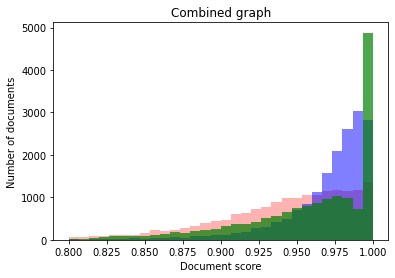

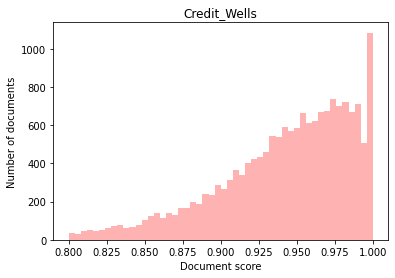

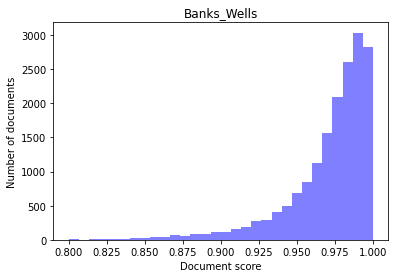

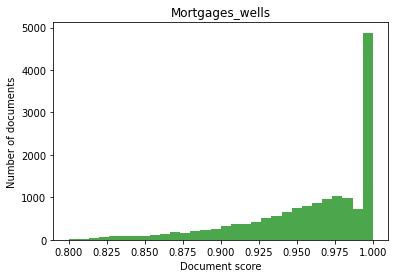

In [ ]:
#plot overlap distribution - tfidf tokenizer - top tfidf words
wells_cu_tfidf_sentence_score=wells_cu_tfidf_overlap_sum
wells_banks_tfidf_sentence_score=wells_banks_tfidf_overlap_sum
wells_mortgages_tfidf_sentence_score=wells_mortgages_tfidf_overlap_sum

plt.title("Combined graph")
plt.xlabel("Document score")
plt.ylabel("Number of documents")
plt.hist(wells_cu_tfidf_sentence_score,alpha=0.3,bins=30,range=(0.8,1),color="red")
plt.hist(wells_banks_tfidf_sentence_score,alpha=0.5,bins=30,range=(0.8,1),color="blue")
plt.hist(wells_mortgages_tfidf_sentence_score,alpha=0.7,bins=30,range=(0.8,1),color="green")
plt.show()

plt.title("Credit_Wells")
plt.xlabel("Document score")
plt.ylabel("Number of documents")
plt.hist(wells_cu_tfidf_sentence_score,alpha=0.3,bins=50,range=(0.8,1),color="red")
plt.show()

plt.title("Banks_Wells")
plt.xlabel("Document score")
plt.ylabel("Number of documents")
plt.hist(wells_banks_tfidf_sentence_score,alpha=0.5,bins=30,range=(0.8,1),color="blue")
plt.show()

plt.title("Mortgages_wells")
plt.xlabel("Document score")
plt.ylabel("Number of documents")
plt.hist(wells_mortgages_tfidf_sentence_score,alpha=0.7,bins=30,range=(0.8,1),color="green")
plt.show()

1.4 Toy Example code

In [ ]:
# code for toy sample
v_1=["debt card is not working","lost my debt card last night","debt card remaining balance amount is wrong"]
v_2=["mortgage payment is not processing","why my mortgage payment not showing up","mortgage payment amount does not look correct"]
test=["debt card is damaged","mortgage payment amount showing error","debt card not functioning at atm machine"]
max_features=4
v1_vectorizer,_=tokenizing(v_1,max_features)
v2_vectorizer,_=tokenizing(v_2,max_features)
test_vectorizer,X_test=tokenizing(test,max_features)
overlap_v1_test=set(v1_vectorizer.get_feature_names())&set(test_vectorizer.get_feature_names())
overlap_v2_test=set(v2_vectorizer.get_feature_names())&set(test_vectorizer.get_feature_names())

In [ ]:
print(f'vendor dataset 1',v_1)
print(f'vendor dataset 2',v_2)
print(f'Wells Fargo dataset',test)
print("")
print("In this toy example, vendor dataset 1 is designed to be similar to test, and vendor dataset 2 is designed to be different to our dataset")
print("")
print(f'most frequent 4 words for vendor dataset 1:', v1_vectorizer.get_feature_names())
print(f'most frequent 4 words for vendor dataset 2:', v2_vectorizer.get_feature_names())
print(f'most frequent 4 words for test:', test_vectorizer.get_feature_names())
print("")
print(f'frequent word overlapping vendor dataset 1 vs our dataset, m=4:',overlap_v1_test)
print(f'frequent word overlapping vendor dataset 2 vs our dataset, m=4:',overlap_v2_test)
print("")
print("overlaping % vendor dataset 1 vs our dataset, m=4: 3/4=0.75")
print("overlaping % vendor dataset 1 vs our dataset, m=4: 1/4=0.25")
print("")
print("tokenizer of our dataset, m=4")
print(test_vectorizer.get_feature_names())
print(X_test.toarray())
print("row sum is [2,1,3], adding a smoothing term of 0.001 our denominators will be [2.001,1.001,3.001]")

vendor dataset 1 ['debt card is not working', 'lost my debt card last night', 'debt card remaining balance amount is wrong']
vendor dataset 2 ['mortgage payment is not processing', 'why my mortgage payment not showing up', 'mortgage payment amount does not look correct']
Wells Fargo dataset ['debt card is damaged', 'mortgage payment amount showing error', 'debt card not functioning at atm machine']

In this toy example, vendor dataset 1 is designed to be similar to test, and vendor dataset 2 is designed to be different to our dataset

most frequent 4 words for vendor dataset 1: ['amount', 'card', 'debt', 'is']
most frequent 4 words for vendor dataset 2: ['amount', 'mortgage', 'not', 'payment']
most frequent 4 words for test: ['amount', 'at', 'card', 'debt']

frequent word overlapping vendor dataset 1 vs our dataset, m=4: {'card', 'debt', 'amount'}
frequent word overlapping vendor dataset 2 vs our dataset, m=4: {'amount'}

overlaping % vendor dataset 1 vs our dataset, m=4: 3/4=0.75
over